# Google Earth Engine Component

## Initialize

In [1]:
!pip install geemap
!pip install keras-tuner --upgrade
!pip install tensorflow==2.8
# !apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2


In [2]:
#Import required libraries
import os
from time import sleep, time
from pprint import pprint
import math
import itertools

# from google.colab import auth, drive

import ee
import geemap
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import keras_tuner

import folium



In [3]:
#Initialize Google Earth Engine
#just needed the 1st time
ee.Authenticate() 
ee.Initialize()

Enter verification code: 4/1AdQt8qgWTjWJyNUZkLihCWb8JMYFX5CYXrc_2RokkanfyCZ3GSkoVg-o3-s

Successfully saved authorization token.


In [4]:
# # Authenticate GDrive and mount folder
# auth.authenticate_user()

# drive.mount('/content/drive')
# %cd drive/MyDrive/mids-w210-capstone/datasets/GoogleEarth

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/datasets/GoogleEarth


In [4]:
# Check if geemap is working as intended - plot the leaflet map
Map = geemap.Map()
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

## Load Feature Collection - Shapefiles

In [5]:
#Data loads

#loads feature collection data from Google Earth Engine - We can also upload other feature collections
counties = ee.FeatureCollection("TIGER/2018/Counties")

#filter LA County
la_county = counties.filter(ee.Filter.eq('NAME', 'Los Angeles'))
sc_county = counties.filter(ee.Filter.eq('NAME', 'Santa Clara'))

#loads parcel data
la_parcel_shape = ee.FeatureCollection("projects/california-lawn-detection/assets/LA_County_Parcels_Shape")

#Income Data
la_county_income = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome-final")
la_county_income2 = ee.FeatureCollection("projects/california-lawn-detection/assets/lacountyincome_update")
la_county_income = la_county_income2.select(ee.List(['Name', 'Descriptio', 'Ranking']), ee.List(['Name', 'Median_Income', 'Ranking']))

## Load NAIP Imagery

In [6]:
def apply_3bands(image, band):
    i_8_bit = image.select(band).toUint8()
    square = ee.Kernel.square(**{'radius': 4})
    entropy = i_8_bit.entropy(square)
    glcm = i_8_bit.glcmTexture(**{'size': 4})
    contrast = glcm.select(str(band)+'_contrast')
    
    # Create a list of weights for a 9x9 kernel.
    list = [1, 1, 1, 1, 1, 1, 1, 1, 1]
    # The center of the kernel is zero.
    centerList = [1, 1, 1, 1, 0, 1, 1, 1, 1]
    # Assemble a list of lists: the 9x9 kernel weights as a 2-D matrix.
    lists = [list, list, list, list, centerList, list, list, list, list]
    # Create the kernel from the weights.
    # Non-zero weights represent the spatial neighborhood.
    kernel = ee.Kernel.fixed(9, 9, lists, -4, -4, False)
    neighs = i_8_bit.neighborhoodToBands(kernel)
    gearys = i_8_bit.subtract(neighs).pow(2).reduce(ee.Reducer.sum()).divide(math.pow(9, 2))
    image = image.addBands(entropy.rename(str(band)+'_Entropy')).addBands(contrast.rename(str(band)+'_Contrast')).addBands(gearys.rename(str(band)+'_Gearys'))   
    return image

def add_neighborhood_bands(image):
    bands = ['R', 'G', 'B', 'N']
    for band in bands:
        image = apply_3bands(image, band)
    return image
    
def add_NDVI(image):
    image = image.addBands(image.normalizedDifference(['N','R']).rename('NDVI'))
    return image
     

In [7]:
def get_images(param_dict):
    source_image_collection = param_dict['source_image_collection']
    years = param_dict['years']
    counties = param_dict['counties']

    image_names = []
    images = []

    combos = list(itertools.product(years, counties.keys()))
    for i in combos:
        year = str(i[0])
        county = i[1]

        image_name = str(i[0])+'_'+i[1]
        image_names.append(image_name)

        image = ee.ImageCollection(source_image_collection)\
                                .filterDate(f'{year}-01-01', f'{year}-12-31')\
                                .select(['R','G','B','N'])\
                                .median().clip(counties[county])
        images.append(image)
        images_with_3band = list(map(add_neighborhood_bands, images))
        images_with_NDVI = list(map(add_NDVI, images_with_3band))
    return dict(zip(image_names, images_with_NDVI))

def conditional_water(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(1),feat.set({'landcover': 0}),feat)

def conditional_trees(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(2),feat.set({'landcover': 1}),feat)

def conditional_grass(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(3),feat.set({'landcover': 2}),feat)

def conditional_turf(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(4),feat.set({'landcover': 3}),feat)

def conditional_impervious(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(6),feat.set({'landcover': 4}),feat)

def conditional_soil(feat):
    return ee.Algorithms.If(ee.Number(feat.get('landcover')).eq(7),feat.set({'landcover': 5}),feat)
    

## Load Labeled Data

In [8]:
## Loading feature collections from Google Earth Engine

# Load in train data

## Loading feature collections from Google Earth Engine

water_1 = ee.FeatureCollection("projects/california-lawn-detection/assets/water_torrance_0610")
water_2 = ee.FeatureCollection("projects/california-lawn-detection/assets/water_torrance_0701_400")
vegetation_trees = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_torrance")
vegetation_grass = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_torrance").limit(400)
turf_1 = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_torrance1")
turf_2 = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_torrance2")
impervious_1 = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_torrance1").limit(35)
impervious_2 = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_torrance2").limit(35)
soil = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_reduced_070222")

water = water_1.merge(water_2)
turf = turf_1.merge(turf_2)
impervious= impervious_1.merge(impervious_2)

water_tr = water.map(conditional_water)
trees_tr = vegetation_trees.map(conditional_trees)
grass_tr = vegetation_grass.map(conditional_grass)
turf_tr = turf.map(conditional_turf)
impervious_tr = impervious.map(conditional_impervious)
soil_tr = soil.map(conditional_soil)

LABELED_SET = water_tr.merge(trees_tr).merge(grass_tr).merge(turf_tr).merge(impervious_tr).merge(soil_tr)

In [9]:
# Load in test data
water_test = ee.FeatureCollection("projects/california-lawn-detection/assets/water_test")
vegetation_trees_test = ee.FeatureCollection("projects/california-lawn-detection/assets/trees_test")
vegetation_grass_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/grass_test")
turf_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/turf_test")
impervious_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/impervious_reduced_test")
soil_test  = ee.FeatureCollection("projects/california-lawn-detection/assets/soil_reduced_070222")

TEST_SET = water_test.merge(vegetation_trees_test).merge(vegetation_grass_test).merge(turf_test).merge(impervious_test).merge(soil_test)

In [10]:
# training information
training_classes_list = [water_tr,
                         trees_tr,
                         grass_tr,
                         turf_tr,
                         impervious_tr,
                         soil_tr]

training_classes_list_text = ['water',
                              'vegetation_trees',
                              'vegetation_grass',
                              'turf',
                              'impervious',
                              'soil']

assert len(training_classes_list) == len(training_classes_list_text)

N_CLASSES = len(training_classes_list)

## Building Training Set

In [11]:
training_image_params = {
        'source_image_collection' : 'USDA/NAIP/DOQQ',
        'years' : [2020],
        'counties': {'la_county': la_county}
         }

TRAINING_IMAGE = get_images(training_image_params)['2020_la_county']

In [12]:
# Overlay the points on the imagery to get training.
LABEL = 'landcover'
BANDS = ['R', 
         'G', 
         'B', 
         'N', 
         'NDVI',
         'R_Entropy',
         'R_Contrast',
         'R_Gearys',
         'G_Entropy',
         'G_Contrast',
         'G_Gearys',
         'B_Entropy',
         'B_Contrast',
         'B_Gearys',
         'N_Entropy', 
         'N_Contrast', 
         'N_Gearys']

train_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': LABELED_SET,
  'properties': [LABEL],
  'scale': 1
})

test_data = TRAINING_IMAGE.select(BANDS).sampleRegions(**{
  'collection': TEST_SET,
  'properties': [LABEL],
  'scale': 1
})

In [13]:
Map.addLayer(TRAINING_IMAGE, {}, 'TRAINING_IMAGE')

In [14]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [16]:
# print("Training Set Size in Pixels", train_data.aggregate_count('R').getInfo())
# print("Test Set Size in Pixels", test_data.aggregate_count('R').getInfo())

### Convert Data Format

In [17]:
# These names are used to specify properties in the export of
# training/testing data and to define the mapping between names and data
FEATURE_NAMES = list(BANDS)
FEATURE_NAMES.append(LABEL)

# File names for the training and testing datasets
IMAGES_DIR = '../datasets/GoogleEarth'
TRAIN_FILE_PREFIX = 'training_allbands_0703'
TEST_FILE_PREFIX = 'testing_allbands_0703' 

In [18]:
def start_export_tasks(train_task, test_task, train_path, test_path):

  # get the start time
  start = time()

  train_task.start()
  test_task.start()

  train_exists = False
  test_exists = False

  while not train_exists or not test_exists:
    
    train_exists = tf.io.gfile.exists(train_path)
    test_exists = tf.io.gfile.exists(test_path)

    if train_exists:
      print('Found training file.')
    else:
      print('No training file found.')

    if test_exists:
      print('Found testing file.')
    else:
      print('No testing file found.')

    sleep(10)
  
  # get the end time
  end = time()

  # get the execution time
  elapsed_time = end - start
  print('Execution time:', elapsed_time, 'seconds')

#### Convert data to TFRecord

In [19]:
# File paths
file_extension = '.tfrecord.gz'
TF_TRAIN_FILE_PATH = os.path.join(os.getcwd(), (TRAIN_FILE_PREFIX + file_extension))
TF_TEST_FILE_PATH = os.path.join(os.getcwd(), (TEST_FILE_PREFIX + file_extension))

In [23]:
# # Export data as TFRecord files

# training_task = ee.batch.Export.table.toDrive(
#   collection=train_data,
#   description='Training Export',
#   fileNamePrefix=TRAIN_FILE_PREFIX,
#   folder=IMAGES_DIR,
#   fileFormat='TFRecord',
#   selectors=FEATURE_NAMES)

# testing_task = ee.batch.Export.table.toDrive(
#   collection=test_data,
#   description='Testing Export',
#   fileNamePrefix=TEST_FILE_PREFIX,
#   folder=IMAGES_DIR,
#   fileFormat='TFRecord',
#   selectors=FEATURE_NAMES)

# start_export_tasks(training_task, testing_task, TF_TRAIN_FILE_PATH, TF_TEST_FILE_PATH)

#### Parse TFRecord into dataset for NN input

In [ ]:
def parse_tfrecord(example_proto, features_dict):
  """The parsing function.

  Read a serialized example into the structure defined by featuresDict.

  Args:
    example_proto: a serialized Example.

  Returns:
    A tuple of the predictors dictionary and the label, cast to an `int32`.
  """
  parsed_features = tf.io.parse_single_example(example_proto, features_dict)
  labels = parsed_features.pop(LABEL)
  return parsed_features, tf.cast(labels, tf.int32)

# Keras requires inputs as a tuple.  Note that the inputs must be in the
# right shape.  Also note that to use the categorical_crossentropy loss,
# the label needs to be turned into a one-hot vector.
def to_tuple(inputs, label):
  return (tf.transpose(list(inputs.values())),
          tf.one_hot(indices=label, depth=N_CLASSES))

def create_tf_dataset(file_path, features, compression_type='GZIP'):

  # Create a dataset from the TFRecord file in GDrive.
  dataset = tf.data.TFRecordDataset(file_path, compression_type='GZIP')

  # List of fixed-length features, all of which are float32.
  columns = [
    tf.io.FixedLenFeature(shape=[1], dtype=tf.float32) for k in features
  ]

  # Dictionary with names as keys, features as values.
  features_dict = dict(zip(features, columns))

  parsed_dataset = dataset.map(lambda x: parse_tfrecord(x, features_dict), num_parallel_calls=5)

  parsed_dataset = parsed_dataset.map(to_tuple)

  return parsed_dataset


In [ ]:
# from pprint import pprint

# train_tf = create_tf_dataset(TF_TRAIN_FILE_PATH, FEATURE_NAMES)
# test_tf = create_tf_dataset(TF_TEST_FILE_PATH, FEATURE_NAMES)

# # Print the first parsed record to check.
# pprint(iter(train_tf).next())
# pprint(iter(test_tf).next())

# # Shuffle train dataset
# train_tf = train_tf.shuffle(128)

# # Print the first parsed record to check (only train should be shuffled)
# pprint(iter(train_tf).next())
# pprint(iter(test_tf).next())


#### Convert data to CSV

In [20]:
file_extension = '.csv'
CSV_TRAIN_FILE_PATH = os.path.join(IMAGES_DIR, (TRAIN_FILE_PREFIX + file_extension))
CSV_TEST_FILE_PATH = os.path.join(IMAGES_DIR, (TEST_FILE_PREFIX + file_extension))

In [21]:
print(CSV_TEST_FILE_PATH)

../datasets/GoogleEarth/testing_allbands_0703.csv


In [17]:
# # Export data as CSV

# training_task = ee.batch.Export.table.toDrive(
#   collection=train_data,
#   description='Training Export',
#   fileNamePrefix=TRAIN_FILE_PREFIX,
#   folder=IMAGES_DIR,
#   fileFormat='CSV',
#   selectors=FEATURE_NAMES)

# testing_task = ee.batch.Export.table.toDrive(
#   collection=test_data,
#   description='Testing Export',
#   fileNamePrefix=TEST_FILE_PREFIX,
#   folder=IMAGES_DIR,
#   fileFormat='CSV',
#   selectors=FEATURE_NAMES)

# start_export_tasks(training_task, testing_task, CSV_TRAIN_FILE_PATH, CSV_TEST_FILE_PATH)

#### Parse CSV data

In [22]:
np.random.seed(123)

In [23]:
train = pd.read_csv(CSV_TRAIN_FILE_PATH).to_numpy()
np.random.shuffle(train)

In [24]:
test = pd.read_csv(CSV_TEST_FILE_PATH).to_numpy()
np.random.shuffle(test)

In [25]:
train_X, train_Y = train[:,:-1], train[:, -1].astype(int)
test_X, test_Y = test[:,:-1], test[:, -1].astype(int)
train_X

array([[ 174.        ,  169.        ,  161.        , ...,    2.7446496 ,
          32.37326389,   23.38271605],
       [  71.        ,   80.        ,   66.        , ...,    3.681755  ,
         236.36414931,  733.81481481],
       [ 153.        ,  150.        ,  138.        , ...,    1.8514943 ,
           7.95833333,    7.61728395],
       ...,
       [  72.        ,   81.        ,   70.        , ...,    3.6208317 ,
         288.33550347,  504.28395062],
       [  60.        ,   77.        ,   56.        , ...,    3.5032933 ,
         111.79774306,  292.13580247],
       [  53.        ,   63.        ,   61.        , ...,    3.783589  ,
         672.20529514, 1594.96296296]])

In [26]:
train_Y

array([4, 2, 4, ..., 1, 1, 1])

In [27]:
sparse_train_Y = np.zeros((train_Y.size, train_Y.max()+1))
sparse_train_Y[np.arange(train_Y.size), train_Y] = 1
sparse_train_Y

array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

In [28]:
sparse_test_Y = np.zeros((test_Y.size, test_Y.max()+1))
sparse_test_Y[np.arange(test_Y.size), test_Y] = 1
sparse_test_Y

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

## Build NN models

### Custom F1 Metric

In [25]:
class MultiClassFBeta(keras.metrics.Metric):
  def __init__(self,  n_class=N_CLASSES, name='macro_f1', beta=1, average='macro', **kwargs):
    # initializing an object of the super class
    super(MultiClassFBeta, self).__init__(name='macro_f1', **kwargs)

    # initializing state variables
    self.tp = self.add_weight(name='tp', shape=(n_class,), initializer='zeros')     # initializing true positives
    self.actual_positives = self.add_weight(name='ap', shape=(n_class,), initializer='zeros') # initializing actual positives
    self.predicted_positives = self.add_weight(name='pp', shape=(n_class,), initializer='zeros') # initializing predicted positives

    # initializing other atrributes that wouldn't be changed for every object of this class
    self.beta_squared = beta**2
    self.n_class = n_class
    self.average = average
    self.epsilon = 1e-7

  def update_state(self, ytrue, ypred, sample_weight=None):

    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # finding the maximum probability in ypred
    max_prob = tf.reduce_max(ypred, axis=-1, keepdims=True)

    # making ypred one hot encoded such that the class with the maximum probability as encoded as 1 while others as 0
    ypred = tf.cast(tf.equal(ypred, max_prob), tf.float32)

    # Calculate TP, PP, AP
    TP = tf.reshape(tf.reduce_sum(ytrue*ypred, axis=0), [self.n_class])
    PP = tf.reshape(tf.reduce_sum(ypred, axis=0), [self.n_class])
    AP = tf.reshape(tf.reduce_sum(ytrue, axis=0), [self.n_class])

    # print(TP.shape)
    # print(PP.shape)
    # print(AP.shape) 

    # for metric in [TP, PP, AP]:
    #   if metric.shape != (self.n_class,):
    #     print("Needs reshaping")
    #     metric = tf.reshape(metric, [self.n_class])

    # print(TP.shape)
    # print(PP.shape)
    # print(AP.shape) 

    self.tp.assign_add(TP) # updating true positives atrribute
    self.predicted_positives.assign_add(PP) # updating predicted positives atrribute
    self.actual_positives.assign_add(AP) # updating actual positives atrribute

  def result(self):
    self.precision = self.tp/(self.predicted_positives+self.epsilon) # calculates precision
    self.recall = self.tp/(self.actual_positives+self.epsilon) # calculates recall

    # calculating fbeta score
    self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)

    if self.average == 'weighted':
      return tf.reduce_sum(self.fb*self.actual_positives / tf.reduce_sum(self.actual_positives))
    
    elif self.average == 'raw':
      return self.fb

    return tf.reduce_mean(self.fb)

  def reset_state(self):
    self.tp.assign(tf.zeros(self.n_class)) # resets true positives to zero
    self.predicted_positives.assign(tf.zeros(self.n_class)) # resets predicted positives to zero
    self.actual_positives.assign(tf.zeros(self.n_class)) # resets actual positives to zero

### KerasTuner

In [26]:
class NNHyperModel(keras_tuner.HyperModel):

    """
    Custom hyperparamater tuning model
    """

    def call_existing_code(self, lr, dropout_rate, hidden_nodes, activation):
        # Define the layers in the model.
        model = tf.keras.models.Sequential([                      
          tf.keras.layers.Dense(hidden_nodes, activation=activation, 
                                input_shape=(N_FEATURES,)),
          tf.keras.layers.Dropout(dropout_rate),
          tf.keras.layers.Dense(N_CLASSES, activation=tf.nn.softmax)
        ])

        # Compile the model with the specified loss function.
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                      loss='categorical_crossentropy',
                      metrics=[MultiClassFBeta(n_class=N_CLASSES), 'accuracy'])
        
        return model

    def build(self, hp):
        
        # Define hyperparameters
        hidden_nodes = hp.Int("hidden_nodes", min_value=16, max_value=64, step=8)
        activation = hp.Choice("activation", ["relu", "tanh"])
        dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
        lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
        
        # call existing model-building code with the hyperparameter values.
        model = self.call_existing_code(
            hidden_nodes=hidden_nodes, activation=activation, 
            dropout_rate=dropout_rate, lr=lr
        )

        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Int("batch_size", min_value=16, max_value=126, step=8),
            **kwargs,
        )

In [27]:
tuning_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "model_tuning_temp")
tuning_dir

'/content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/model_tuning_temp'

In [30]:
N_FEATURES = len(FEATURE_NAMES) - 1

# Use GPU instead
with tf.device('/device:GPU:0'):

  # Random Search
  # NN_tuner = keras_tuner.RandomSearch(
  #     hypermodel=NNHyperModel(),
  #     objective=keras_tuner.Objective("val_macro_f1", direction="max"),
  #     max_trials=15,
  #     executions_per_trial=2,
  #     overwrite=True,
  #     directory=tuning_dir,
  #     project_name="NN",
  # )

  # BayesianSearch
  NN_tuner = keras_tuner.BayesianOptimization(
      hypermodel=NNHyperModel(),
      objective=keras_tuner.Objective("val_macro_f1", direction="max"),
      max_trials=30,
      beta=2,
      executions_per_trial=2,
      overwrite=True,
      directory=tuning_dir,
      project_name="NN",
  )

  
  # TFRecord call
  # NN_tuner.search(train_tf, verbose=2, validation_data=test_tf, 
  #                 epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping('val_macro_f1', patience=3, 
  #                                                                        mode='max', restore_best_weights=True)])
  
  # CSV call
  NN_tuner.search(x=train_X, y=sparse_train_Y, verbose=2, validation_data=(test_X, sparse_test_Y), 
                  epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping('val_macro_f1', patience=3, 
                                                                         mode='max', restore_best_weights=True)])



Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
56                |?                 |hidden_nodes
tanh              |?                 |activation
0.2               |?                 |dropout_rate
0.0022937         |?                 |lr

Epoch 1/30
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
15555/15555 - 44s - loss: 0.5523 - macro_f1: 0.5132 - accuracy: 0.7997 - val_loss: 1.0538 - val_macro_f1: 0.4292 - val_accuracy: 0.6901 - 44s/epoch - 3ms/step
Epoch 2/30


KeyboardInterrupt: ignored

In [ ]:
best_nn_model = NN_tuner.get_best_models()[0]

# Save model weights
save_dir = f"{os.path.join(os.path.dirname(tuning_dir), 'notebooks/models', f'NN_model_{time()}')}"
print(save_dir)
best_nn_model.save(save_dir)

/content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/notebooks/models/NN_model_1657056310.9799173
INFO:tensorflow:Assets written to: /content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/notebooks/models/NN_model_1657056310.9799173/assets


In [28]:
save_dir = '/content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/notebooks/models/NN_model_1657056310.9799173'

In [29]:
# Load and evaluate model to test it's the same performance

best_nn_model = tf.keras.models.load_model(save_dir, custom_objects={'MultiClassFBeta': MultiClassFBeta})

# TFRecord evaluation
# best_nn_model.evaluate(test_tf)

# CSV evaluation
best_nn_model.evaluate(test_X, sparse_test_Y)


487/487 [==============================] - 6s 5ms/step - loss: 0.2516 - macro_f1: 0.8991 - accuracy: 0.9118


[0.25160863995552063, 0.899054765701294, 0.911776065826416]

### Test model with CONV layers

In [28]:
print(train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1])).shape)
print(sparse_train_Y.reshape((sparse_train_Y.shape[0], 1, 1, sparse_train_Y.shape[1])).shape)
print(test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1])).shape)
print(sparse_test_Y.reshape((sparse_test_Y.shape[0], 1, 1, sparse_test_Y.shape[1])).shape)

(248876, 1, 1, 17)
(248876, 1, 1, 6)
(15574, 1, 1, 17)
(15574, 1, 1, 6)


In [29]:
conv_train_X = train_X.reshape((train_X.shape[0], 1, 1, train_X.shape[1]))
conv_sparse_train_Y = sparse_train_Y.reshape((sparse_train_Y.shape[0], 1, 1, sparse_train_Y.shape[1]))
conv_test_X = test_X.reshape((test_X.shape[0], 1, 1, test_X.shape[1]))
conv_sparse_test_Y = sparse_test_Y.reshape((sparse_test_Y.shape[0], 1, 1, sparse_test_Y.shape[1]))

In [30]:
# Define the layers in the model.  Note the 1x1 kernels.
test_model = tf.keras.models.Sequential([
  tf.keras.layers.Input((None, None, len(BANDS),)),
  tf.keras.layers.Conv2D(64, (1,1), activation=tf.nn.relu),
  tf.keras.layers.Dropout(0.05),
  tf.keras.layers.Conv2D(N_CLASSES, (1,1), activation=tf.nn.softmax)
])

# Compile the model with the specified loss and optimizer functions.
test_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=[MultiClassFBeta(n_class=N_CLASSES), 'accuracy'])

# Fit the model to the training data
test_model.fit(x=conv_train_X, y=conv_sparse_train_Y, verbose=2, validation_data=(conv_test_X, conv_sparse_test_Y), batch_size=32, 
                  epochs=30, callbacks=[tf.keras.callbacks.EarlyStopping('val_macro_f1', patience=3, 
                                                                         mode='max', restore_best_weights=True)])

Epoch 1/30


KeyboardInterrupt: ignored

In [ ]:
# Save model weights
save_dir = f"{os.path.join(os.path.dirname(tuning_dir), 'notebooks/models', f'test_CNN_model_{time()}')}"
print(save_dir)
test_model.save(save_dir)

In [31]:
save_dir = '/content/drive/.shortcut-targets-by-id/1mRwyYg9HhgRQ60eg_rdluYYUqf79QYEE/mids-w210-capstone/notebooks/models/test_CNN_model_1657321055.5476348'

# Load and evaluate model to test it's the same performance

best_nn_model = tf.keras.models.load_model(save_dir, custom_objects={'MultiClassFBeta': MultiClassFBeta})

# TFRecord evaluation
# best_nn_model.evaluate(test_tf)

# CSV CNN evaluation
best_nn_model.evaluate(conv_test_X, conv_sparse_test_Y)


487/487 [==============================] - 7s 4ms/step - loss: 0.2501 - macro_f1: 0.8893 - accuracy: 0.9102


[0.25005972385406494, 0.8893359303474426, 0.9102349877357483]

## Evaluate model

In [44]:
y_probs = best_nn_model.predict(conv_test_X)
y_preds = y_probs.argmax(axis=-1)

# If conv output, convert to 2d array
if len(y_preds.shape) > 2:
  y_preds = y_preds.reshape(-1, 1)

y_preds.shape

(15574, 1)

In [47]:
print(classification_report(test_Y, y_preds, target_names=training_classes_list_text))

                  precision    recall  f1-score   support

           water       0.99      0.97      0.98       275
vegetation_trees       0.92      0.90      0.91      2801
vegetation_grass       0.74      0.88      0.80      1532
            turf       0.97      0.91      0.94       860
      impervious       0.63      0.93      0.75      1103
            soil       0.99      0.92      0.95      9003

        accuracy                           0.91     15574
       macro avg       0.87      0.92      0.89     15574
    weighted avg       0.93      0.91      0.91     15574



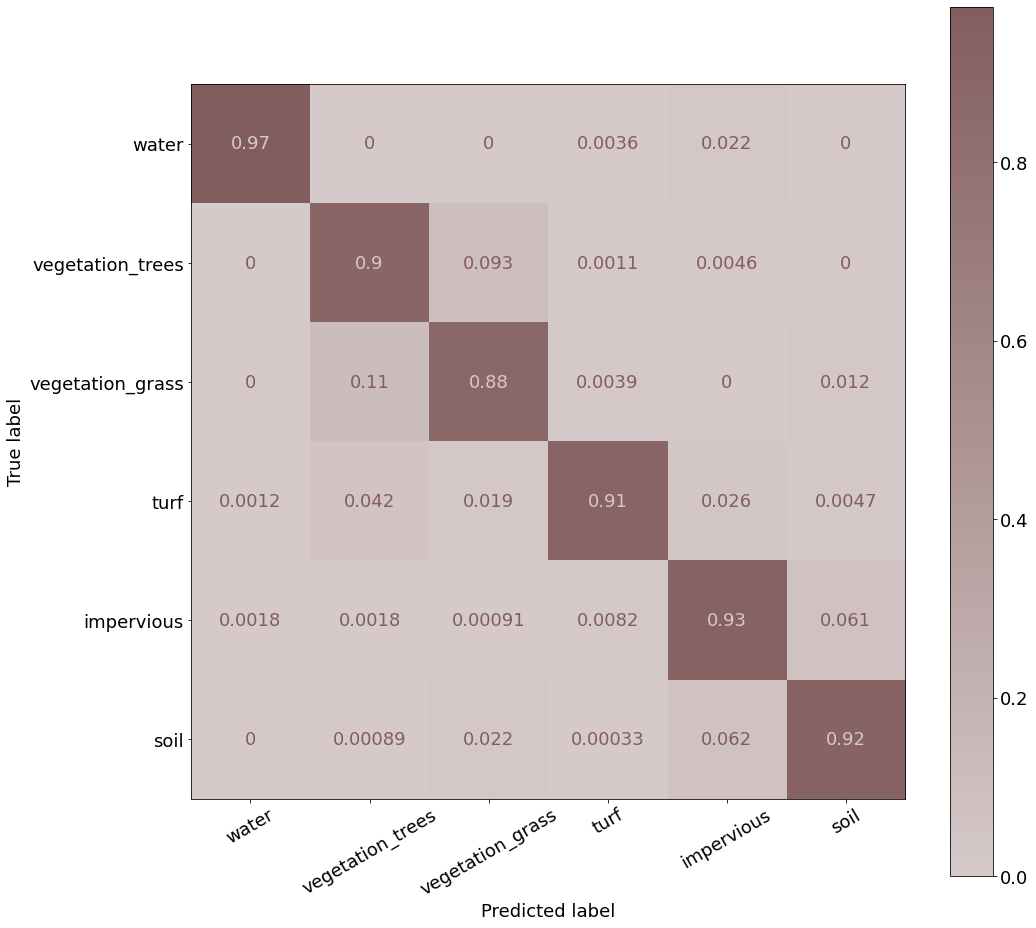

In [49]:
plt.rcParams.update({'text.color': "black",
                     'font.size' : 18,
                     })

fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)

# Create brown colormap
color_scale = 256
color_vals = np.ones((color_scale, 4))
brown_R = 90/256
brown_G = brown_B = 40/256
mult = 0.75
brown_R_start, brown_R_end = brown_R+(1-brown_R)*(1-mult), brown_R+(1-brown_R)*(mult)
brown_G_start, brown_G_end = brown_G+(1-brown_G)*(1-mult), brown_G+(1-brown_G)*(mult)
brown_B_start, brown_B_end = brown_G_start, brown_G_end

color_vals[:, 0] = np.linspace(brown_R_start, brown_R_end, color_scale)[::-1]
color_vals[:, 1] = np.linspace(brown_G_start, brown_G_end, color_scale)[::-1]
color_vals[:, 2] = np.linspace(brown_B_start, brown_B_end, color_scale)[::-1]
brown_cmp = ListedColormap(color_vals)

ConfusionMatrixDisplay.from_predictions(test_Y, y_preds, display_labels=training_classes_list_text, ax=ax, normalize='true', 
                                        cmap=brown_cmp, xticks_rotation=30)

plt.show()

## EEificiation

In [50]:
from tensorflow.python.tools import saved_model_utils

meta_graph_def = saved_model_utils.get_meta_graph_def(save_dir, 'serve')
inputs = meta_graph_def.signature_def['serving_default'].inputs
outputs = meta_graph_def.signature_def['serving_default'].outputs

# Just get the first thing(s) from the serving signature def.  i.e. this
# model only has a single input and a single output.
input_name = None
for k,v in inputs.items():
  input_name = v.name
  break

output_name = None
for k,v in outputs.items():
  output_name = v.name
  break

# Make a dictionary that maps Earth Engine outputs and inputs to
# AI Platform inputs and outputs, respectively.
import json
input_dict = "'" + json.dumps({input_name: "array"}) + "'"
output_dict = "'" + json.dumps({output_name: "output"}) + "'"
print(input_dict)
print(output_dict)

'{"serving_default_input_1:0": "array"}'
'{"StatefulPartitionedCall:0": "output"}'


In [29]:
# Put the EEified model in the appropriate bucket and API name
PROJECT = 'w210-351617'
OUTPUT_BUCKET = 'test-tf-gee'
EEIFIED_DIR = 'gs://' + OUTPUT_BUCKET + '/eeified_pixel_model'

MODEL_NAME = 'test_CNN_model'
VERSION_NAME = 'v0'
REGION = 'us-central1'

In [51]:
# Run the model prepare commands
!earthengine set_project {PROJECT}
!earthengine model prepare --source_dir {save_dir} --dest_dir {EEIFIED_DIR} --input {input_dict} --output {output_dict}

Successfully saved project id
Success: model at 'gs://test-tf-gee/eeified_pixel_model' is ready to be hosted in AI Platform.


In [52]:
# Create API endpoint hosted on Google AI Platform
!gcloud ai-platform models create {MODEL_NAME} \
  --project {PROJECT} \
  --region {REGION}

!gcloud ai-platform versions create {VERSION_NAME} \
  --project {PROJECT} \
  --region {REGION} \
  --model {MODEL_NAME} \
  --origin {EEIFIED_DIR} \
  --framework "TENSORFLOW" \
  --runtime-version=2.3 \
  --python-version=3.7

Using endpoint [https://us-central1-ml.googleapis.com/]
Created ai platform model [projects/w210-351617/models/test_CNN_model].
Using endpoint [https://us-central1-ml.googleapis.com/]


## Visualize model predictions

In [30]:
# Point to the model hosted on AI Platform.  If you specified a region other
# than the default (us-central1) at model creation, specify it here.
final_model = ee.Model.fromAiPlatformPredictor(
    projectName=PROJECT,
    modelName=MODEL_NAME,
    version=VERSION_NAME,
    # Can be anything, but don't make it too big.
    inputTileSize=[12, 12],
    # # Keep this the same as your training data.
    proj=ee.Projection('EPSG:4326').atScale(30),
    fixInputProj=True,
    # Note the names here need to match what you specified in the
    # output dictionary you passed to the EEifier.
    outputBands={'output': {
        'type': ee.PixelType.float(),
        'dimensions': 1
      }
    },
)

In [27]:
print(type(la_image))

NameError: ignored

In [31]:
la_image = TRAINING_IMAGE.select(BANDS)

predictions = final_model.predictImage(la_image.float().toArray())
probabilities = predictions.arrayFlatten([training_classes_list_text])
label = predictions.arrayArgmax().arrayGet([0]).rename('label')


# # Get map IDs for display in folium.
# probability_vis = {
#     'bands': BANDS, 'max': 0.5, 'format': 'png'
# }
# label_vis = {
#     'palette': ['red', 'green', 'blue'], 'min': 0, 'max': 5, 'format': 'png'
# }
# probability_mapid = probabilities.getMapId(probability_vis)
# label_mapid = label.getMapId(label_vis)

In [32]:
label.getInfo()

{'type': 'Image',
 'bands': [{'id': 'label',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -2147483648,
    'max': 2147483647},
   'crs': 'EPSG:4326',
   'crs_transform': [0.00026949458523585647,
    0,
    0,
    0,
    0.00026949458523585647,
    0]}]}

In [33]:
legend_keys = ['water', 'vegetation_trees', 'vegetation_grass', 'turf','impervious','soil']
legend_colors = ['#0B6AEF', '#097407', '#0CE708', '#8C46D2' ,' #A1A8AF','#D47911']

# Map.addLayer(predictions, {'min': 0, 'max': 5}, 'Classification')

Map.addLayer(label,{'min': 0, 'max': 5, 'palette': legend_colors},"Image")

In [34]:
Map

Map(bottom=754.0, center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(…

In [74]:
import ipyleaflet
m = ipyleaflet.Map()
m

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

In [73]:
print(Map)

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(ToggleButton(value=False, icon='globe', layout=Layout(height='28px', padding='0px 0px 0px 4px', width='28px'), tooltip='Search location/data'),))), ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text', 'zoom_out_title']), ScaleControl(options=['imperial', 'max_width', 'metric', 'position', 'update_when_idle'], position='bottomleft'), FullScreenControl(options=['position']), MeasureControl(active_color='orange', options=['active_color', 'capture_z_index', 'completed_color', 'popup_options', 'position', 'primary_area_unit', 'primary_length_unit', 'secondary_area_unit', 'secondary_length_unit'], popup_options={'className': 'leaflet-measure-resultpopup', 'autoPanPadding': [10, 10]}, position='bottomleft', primary_length_unit='kilometers'), AttributionControl(options=['position', 'prefix'], position='bottomright'), DrawControl(circle={'shapeOptions': {'color

### Try Folium

In [2]:
# Get a map ID for display in folium.
rgb_vis = {'bands': ['R', 'G', 'B'], 'min': 0, 'max': 0.3, 'format': 'png'}
mapid = la_image.getMapId(rgb_vis)

# Get map IDs for display in folium.
probability_vis = {
    'bands': legend_keys[:3], 'max': 0.5, 'format': 'png'
}
label_vis = {
    'palette': legend_colors[:3], 'min': 0, 'max': 2, 'format': 'png'
}
probability_mapid = probabilities.getMapId(probability_vis)
label_mapid = label.getMapId(label_vis)

# Visualize the input imagery and the predictions.
map = folium.Map(location=[34.0522, -118.2437], zoom_start=11)

folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name='median composite',
  ).add_to(map)
folium.TileLayer(
  tiles=label_mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='predicted label',
).add_to(map)
folium.TileLayer(
  tiles=probability_mapid['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='probability',
).add_to(map)
map.add_child(folium.LayerControl())
map

## Image to Array (In progress)

In [ ]:
image_array = classified2020.toArray()

In [ ]:
image_array

In [ ]:
image_array.getInfo()

{'type': 'Image',
 'bands': [{'id': 'array',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': -2147483648,
    'max': 2147483647,
    'dimensions': 1},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [ ]:
np_arr = np.array(image_array)

In [ ]:
np_arr

array(<ee.image.Image object at 0x00000230513085B0>, dtype=object)